In [14]:
import tensorflow as tf 
import numpy as np 
import matplotlib.pyplot as plt
import tensorflow_probability as tfp
import math 
import idx2numpy
%matplotlib inline

In [84]:
# load the data 
train_x = idx2numpy.convert_from_file('./data/train-images-idx3-ubyte')
train_y = idx2numpy.convert_from_file('./data/train-labels-idx1-ubyte')
test_x = idx2numpy.convert_from_file('./data/t10k-images-idx3-ubyte')
test_y = idx2numpy.convert_from_file('./data/t10k-labels-idx1-ubyte')

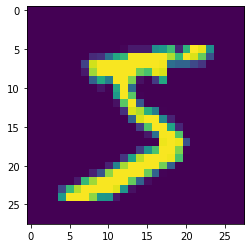

In [85]:
plt.imshow(train_x[0,:])
plt.show()

In [ ]:
def createmvn(kernel_matrix): 
    mu, cov = np.zeros(tf.shape(kernel).numpy()[0]), tf.linalg.inv(kernel)

In [197]:
# Section 1 Question 2
# Sampling from a centered kernel. 

def myarray(size, func): 
    matrix = np.zeros((size, size))
    for i in range(0, size): 
        for j in range(0, size): 
            matrix[i, j] = func(i, j)
    return matrix

def create_kernel_matrix(kernelfunc, data, diag_add=1e-6):  
    # make matrix diagonally dominant.
    return np.add(myarray(data.shape[0], lambda i, j: kernelfunc(data[int(i)] , data[int(j)])), np.identity(data.shape[0]) * diag_add)  

def create_normal_distribution(kernel): 
    mu, cov = np.zeros(tf.shape(kernel).numpy()[0]), tf.linalg.inv(kernel)
    scale = tf.linalg.cholesky(cov)
    return tfp.distributions.MultivariateNormalTriL(loc=mu,scale_tril=scale)

def sampleRKHS(kernelfunc, data, ssize=12, center=True, rkhs_range=(-4,4), func_precision=100, diag_add=1e-5):
    """
    kernelfunc - lambda func that defines the kernel matrix of size dsize x dsize
    dsize - number of elements in the original dataset. 
    ssize - sample size, how many functions from RKHS to sample
    rkhs_range - what range to display the RKHS functions on
    func_precision - how many points to genereate in the rkhs_range (to draw lines) i.e resolution of lines

    returns X, Y -> X: domain values with shape(func_precision, ssize) Y: y values sampled RKHS functions 
    shape(func_precision, ssize) each col represents x and y values of each sampled function. 
    """

    K = create_kernel_matrix(kernelfunc, data, diag_add) 
    if center: 
        IU = np.identity(data.shape[0]) - np.full((data.shape[0], data.shape[0]), 1 / data.shape[0])
        K = np.matmul(K, np.matmul()


    mvn = create_normal_distribution(K) 
    xi = np.linspace(rkhs_range[0], rkhs_range[1], func_precision) # this will be the domain we will be looking at of the RKHS space. 

    # create a matrix that will store the domains of the sampled value (linespace).
    # each column will be the same since we are analyzing them in the same domain.  
    y = np.reshape(xi.T, (xi.shape[0], 1)) # create a transpose of x (since each col will represent the points we are eval at)
    X_f = y
    X_k = y
    for i in range (0, ssize - 1): # range == # of datums in original dataset. 
        X_f = np.concatenate((X_f, y), axis=1)
    
    for i in range(0, data.shape[0] - 1): 
        X_k = np.concatenate((X_k, y), axis=1)

    
    # create functions evaluated at the 10 different basis functions 
    # each basis function is a kernel evaluated at each point holding second variable constant. 
    # in this case we are evaluating the second variable at (almost) all possible points (large number of rows representing domain)
    Kx = np.zeros((X_k.shape[0], data.shape[0]))


    for i in range(Kx.shape[0]): 
        for j in range(Kx.shape[1]):
            Kx[i, j] = kernelfunc(data[j], X_k[i, j])
    
    
    # now create the weighted functions now representing the actual functions in RKHS. 
    alphas = mvn.sample([ssize]).numpy() # sample the alpha weights by which each kernel function will be weighed. 
    # each fx will need its own alpha. Amount sampled is the amount of sample functions we want to generate. 
    Fx = np.matmul(Kx, alphas.T)
    return X_f, Fx

In [198]:
mean = [0, 0]
cov = [[25, 0], [0, 100]] 
x = np.random.multivariate_normal(mean, cov, 5)
print(x)

[[-2.99783416 -6.2975891 ]
 [ 1.57767885  6.63982676]
 [ 3.56543699 -4.86293142]
 [ 6.91425259 -0.34540303]
 [-1.06581407 -6.43787169]]


In [199]:
mu = np.array([0, 0], dtype=float)
cov = np.array([[25, 0], [0, 100]], dtype=float)
scale = tf.linalg.cholesky(cov)
mvn = tfp.distributions.MultivariateNormalTriL(loc=mu,scale_tril=scale)
alphas = mvn.sample([5]).numpy()
print(alphas)

[[ -4.22857606  18.53962595]
 [ -1.01936092 -10.91566367]
 [  2.07454682  -7.81519257]
 [  8.3607396   -8.79402977]
 [  3.97583668  12.26325691]]


In [206]:
def k_c(kernel, data, x,y): 
    average_x = 0 
    average_y = 0
    average_ij = 0
    for i in range(0, data.shape[0]):
       average_x += kernel(x,data[i])
       average_y += kernel(y,data[i])
       for j in range(0, data.shape[0]): 
           average_ij += kernel(data[i],data[j]) 
    average_x /= 11 
    average_y /= 11 
    average_ij /= 121 
    return kernel(x,y) - average_x - average_y + average_ij

In [207]:
data = np.array([i for i in range(-10, 1)])

In [213]:
t = 0.8
gausskernel = lambda i, j: np.exp((-1.0 /  ( 2.0 * t**2 )) * (i - j))
gausskernel_c = lambda x,y: k_c(gausskernel, data, x, y)
data = np.array([i for i in range(-10, 1)])
xi = np.linspace(-4, 4, 100)
km = myarray(gausskernel_c, data, diag_add=1e-6) 
print(np.linalg.inv(km))
x = np.random.multivariate_normal(np.zeros(tf.shape(km).numpy()[0]), np.linalg.inv(km), 5)
print(x)

[[ 8.31602503e+11 -6.29996145e+11 -1.29214759e+12 -1.57997717e+12
  -1.67828059e+12 -1.65017221e+12 -1.47760524e+12 -1.04978655e+12
  -9.20413489e+10  2.01053559e+12  6.60786875e+12]
 [ 8.31602218e+11 -6.29995165e+11 -1.29214794e+12 -1.57997767e+12
  -1.67828115e+12 -1.65017278e+12 -1.47760577e+12 -1.04978695e+12
  -9.20414698e+10  2.01053608e+12  6.60787059e+12]
 [ 8.31602335e+11 -6.29996015e+11 -1.29214678e+12 -1.57997750e+12
  -1.67828098e+12 -1.65017262e+12 -1.47760563e+12 -1.04978687e+12
  -9.20415019e+10  2.01053580e+12  6.60786976e+12]
 [ 8.31602443e+11 -6.29995987e+11 -1.29214778e+12 -1.57997652e+12
  -1.67828101e+12 -1.65017265e+12 -1.47760567e+12 -1.04978690e+12
  -9.20415226e+10  2.01053580e+12  6.60786981e+12]
 [ 8.31602466e+11 -6.29995954e+11 -1.29214775e+12 -1.57997749e+12
  -1.67827997e+12 -1.65017261e+12 -1.47760563e+12 -1.04978688e+12
  -9.20415291e+10  2.01053574e+12  6.60786962e+12]
 [ 8.31602447e+11 -6.29995917e+11 -1.29214769e+12 -1.57997741e+12
  -1.67828090e+12 -

In [208]:
t = 0.8
gausskernel = lambda i, j: np.exp((-1.0 /  ( 2.0 * t**2 )) * (i - j))
gausskernel_c = lambda x,y: k_c(gausskernel, data, x, y)
data = np.array([i for i in range(-10, 1)])
xi = np.linspace(-4, 4, 100)
kernel_matrix = create_kernel_matrix(gausskernel_c, data, diag_add=1) 
print(kernel_matrix)
mvn = create_normal_distribution(kernel_matrix) 

[[-7.57152456e+02 -5.32346151e+02 -4.26920126e+02 -3.74187270e+02
  -3.40291285e+02 -3.03469792e+02 -2.40082135e+02 -1.09431271e+02
   1.72365120e+02  7.86229950e+02  2.12628542e+03]
 [-5.34072519e+02 -3.07908249e+02 -2.04884555e+02 -1.55214672e+02
  -1.28008837e+02 -1.05799975e+02 -7.43292369e+01 -1.33913334e+01
   1.16137952e+02  3.97420846e+02  1.01105058e+03]
 [-4.31481248e+02 -2.06610923e+02 -1.02229263e+02 -5.49617118e+01
  -3.08188507e+01 -1.53001382e+01  1.55796962e+00  3.05789539e+01
   9.03952783e+01  2.19411067e+02  5.00458866e+02]
 [-3.84511542e+02 -1.59775794e+02 -5.66880793e+01 -8.06256193e+00
   1.36779676e+01  2.61337064e+01  3.63016645e+01  5.07100184e+01
   7.86094236e+01  1.37912252e+02  2.66692945e+02]
 [-3.63007243e+02 -1.38333110e+02 -3.53799725e+01  1.19516002e+01
   3.50500955e+01  4.51035028e+01  5.22084871e+01  5.99266913e+01
   7.32134661e+01  1.00599375e+02  1.59667107e+02]
 [-3.53161858e+02 -1.28515933e+02 -2.56244104e+01  2.15725846e+01
   4.33771353e+01  

InvalidArgumentError: Cholesky decomposition was not successful. The input might not be valid. [Op:Cholesky]

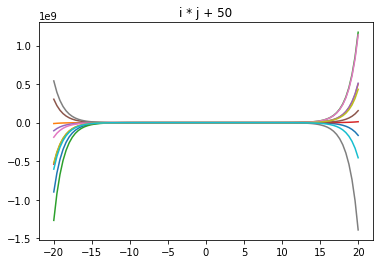

In [131]:
t = 0.8
gausskernel = lambda i, j: np.exp((-1.0 /  ( 2.0 * t**2 )) * (i - j))
gausskernel_c = lambda x,y: k_c(gausskernel, x, y)
x, y = sampleRKHS(gausskernel_c, dsize=11, rkhs_range=(-20,20), diag_add=1e-5)
plt.title('i * j + 50')
for i in range(0, 10): 
    plt.plot(x[:, i], y[:, i])

In [18]:
polykernel = lambda i, j: np.power(i*j+600, 2)
polykernel_c = lambda x,y: k_c(polykernel, x, y)

In [20]:
linear = lambda i, j: i * j + 50
linear_c = lambda x,y: k_c(linear, x, y)

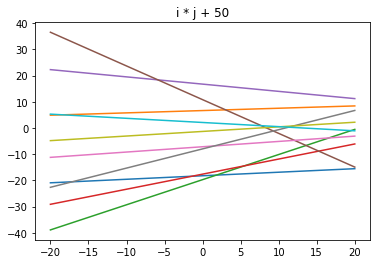

In [47]:
x, y = sampleRKHS(linear_c, dsize=11, shift=11, rkhs_range=(20,-20))
plt.title('i * j + 50')
for i in range(0, 10): 
    plt.plot(x[:, i], y[:, i])

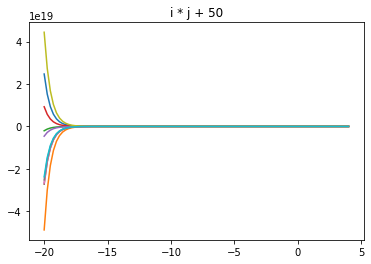

In [97]:
x, y = sampleRKHS(gausskernel_c, dsize=11, shift=-11, rkhs_range=(-20,4), diag_add=1e-5)
plt.title('i * j + 50')
for i in range(0, 10): 
    plt.plot(x[:, i], y[:, i])

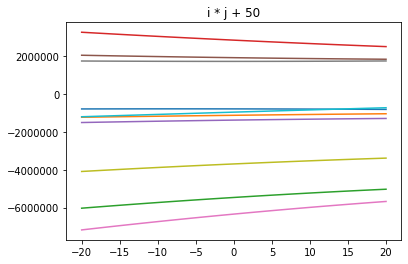

In [36]:
x, y = sampleRKHS(polykernel_c, dsize=11, shift=-11, rkhs_range=(20,-20))
plt.title('i * j + 50')
for i in range(0, 10): 
    plt.plot(x[:, i], y[:, i])

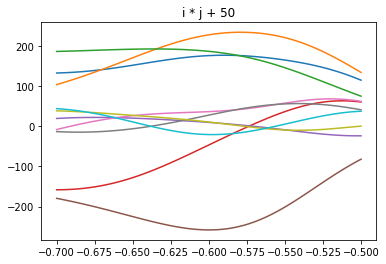

In [121]:
tanh = lambda i, j: np.tanh(i * j + 10)
tanh_c = lambda x,y: k_c(tanh, x, y)
x, y = sampleRKHS(tanh_c, dsize=11, shift=-11, rkhs_range=(-.7,-.5), diag_add=1e-3)
plt.title('i * j + 50')
for i in range(0, 10): 
    plt.plot(x[:, i], y[:, i])

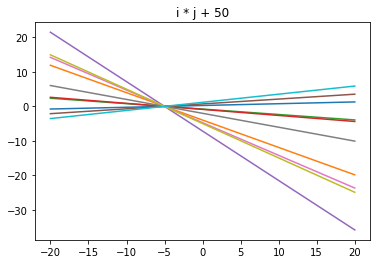

In [112]:
x, y = sampleRKHS(linear_c, dsize=10, shift=-11, rkhs_range=(20,-20))
plt.title('i * j + 50')
for i in range(0, 10): 
    plt.plot(x[:, i], y[:, i])